https://www.youtube.com/watch?v=6CEld3hZgqc&list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&index=5&pp=iAQB

In [10]:
# pytorch model and training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image datasets and manipulation
import torchvision
import torchvision.transforms as transforms

# image display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# pytorch tensorboard support
from torch.utils.tensorboard import SummaryWriter

In [11]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [12]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

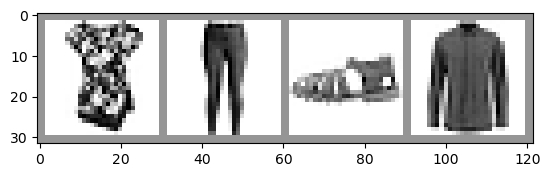

In [13]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [23]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
# tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

### Graphing Scalars to Visualize Training

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))        
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
print(len(validation_loader))
for epoch in range(1):
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # apply gradients and update weights

        running_loss += loss.item()
        if i % 1000 == 999: # Every 1000 mini-batches
            print('Batch {}'.format(i+1))
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't neet to track gradients for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss', 
                               {'Training' : avg_loss, 'Validation' : avg_vloss},
                               epoch * len(training_loader) + i)
            running_loss = 0.0
print('Finished Training')
writer.flush()

2500


/home/nzr170/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


### Visualizing Model

In [19]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph will trace the sample input through the model,
# ad render it as a graph
writer.add_graph(net, images)
writer.flush()

In [24]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28*28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.flush()

In [25]:
writer.close()